In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_only_memory, simulate_2d_only_memory_anharmonic_2

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

import pandas as pd

In [2]:
pool = Pool(4)

In [3]:
def get_cov(R,S,H):
    Z = np.zeros(len(R))
    return np.array([[R,Z,Z,H],
                     [Z,R,-H,Z],
                     [Z,-H,S,Z],
                     [H,Z,Z,S]])

def get_RSH(A,B,g0,b,ka):
    o0 = np.sqrt(-A)
    mu = ka
    S = 1/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    R = 1/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    H = - 1/2/g0/ka**2*b
    
    return R,S,H, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [4]:
# params - A,B,C,D,F,g0,b,ka

params = [
]

bs =  np.array([0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30])/10
# bs =  (0,3,6,10)#,12,14,16,18,20,22,24,26,28,30)
params += [(-7,0,0,0,0,100,b,10) for b in bs]
# params += [(2,0.14,0,0,0,100,b,10) for b in bs]
params += [(2,0.14,0.25,0.01,5,100,b,10) for b in bs]
params += [(2,0.14,0.50,0.01,5,100,b,10) for b in bs]
params += [(2,0.14,0.75,0.01,5,100,b,10) for b in bs]
params += [(2,0.14,1.00,0.01,5,100,b,10) for b in bs]


df = pd.DataFrame(params, columns=["A","B","C","D","F","g0","b","ka"])

In [5]:
def f(row):
    return pd.Series(get_RSH(row.A, row.B, row.g0, row.b, row.ka),index=("R","S","H","varL"))
df = pd.concat([df, df.apply(f, axis=1)], axis=1, sort=False)

df["S_init"] = 1/df.g0/2/df.ka**2*(df.ka**2+df.g0*df.ka+df.b**2)

df["R_init"] = df.A/df.B/2
df.loc[df.A<0,"R_init"] = 7

df["H_init"] = - 1/2/df.g0/df.ka**2*df.b

/home/ashot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [6]:
df["S_init"] = 0
df["R_init"] = 0
df["H_init"] = 0

In [7]:
df.head()

,A,B,C,D,F,g0,b,ka,R,S,H,varL,S_init,R_init,H_init
0,-7,0.0,0.0,0.0,0,100,0.0,10,0.000764,0.055350,-0.000000,0.000085,0,0,0
1,-7,0.0,0.0,0.0,0,100,0.1,10,0.000764,0.055351,-0.000005,0.000085,0,0,0
2,-7,0.0,0.0,0.0,0,100,0.2,10,0.000764,0.055352,-0.000010,0.000085,0,0,0
3,-7,0.0,0.0,0.0,0,100,0.3,10,0.000764,0.055355,-0.000015,0.000085,0,0,0
4,-7,0.0,0.0,0.0,0,100,0.4,10,0.000764,0.055358,-0.000020,0.000085,0,0,0


In [8]:
N=2000000
warmup=0
dt=0.001
samples=400
skip=1000
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [9]:
(len(df) * N * runs * samples *4 // skip) * 4 / 1024**3

4.5299530029296875

In [10]:
get_cov(df.R_init, df.S_init, df.H_init).shape

(4, 4, 95)

In [11]:
results = []
sigmas = get_cov(df.R_init, df.S_init, df.H_init).transpose(2,0,1)

In [12]:
sigmas[5]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [13]:
for row, sigma in tqdm(zip(df.itertuples(),sigmas), total=len(df)):
#     if row.Index <40:
#         continue
    x0,y0,vx0,vy0 = np.random.multivariate_normal([0,0,0,0], sigma, samples).T
    kwargs = dict(x0=x0,y0=y0,vx0=vx0,vy0=vy0,
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=row.A,B=row.B,C=row.C,D=row.D,F=row.F,
        gamma0=row.g0,b=row.b, kappa=row.ka)
    res = simulate_2d_only_memory_anharmonic_2(pool,runs,**kwargs)
    if dump_to_disk:
        np.save(f"results/{row.Index}", res)
    else:
        results.append(np.array(res[:4], dtype="float32"))

In [14]:
results = np.array(results)

### Load dumped data

In [ ]:
import os
n_files = len(os.listdir("results"))

In [ ]:
np.load("results/1.npy").shape

In [ ]:
results = np.zeros((n_files, 4, 800, 5000))

In [ ]:
for i in tqdm(range(n_files)):
    results[i] = np.load(f"results/{i}.npy")[:4,:,-5000:]

In [18]:
results[:,:,:,:].shape

(57, 4, 800, 10000)

### Start Analisys

In [15]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)
# cov = cov[df[df.b].index]

In [16]:
cov.shape

(95, 2000, 4, 4)

In [17]:
sp = 10
cov_R = cov[:,::sp,(0,1),(0,1)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_S = cov[:,::sp,(2,3),(2,3)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_H = cov[:,::sp,(0,1,2,3),(3,2,1,0)].transpose(1,0,2).reshape(-1, cov.shape[0]*4)
cov_Z = cov[:,::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(1,0,2).reshape(-1, cov.shape[0]*8)

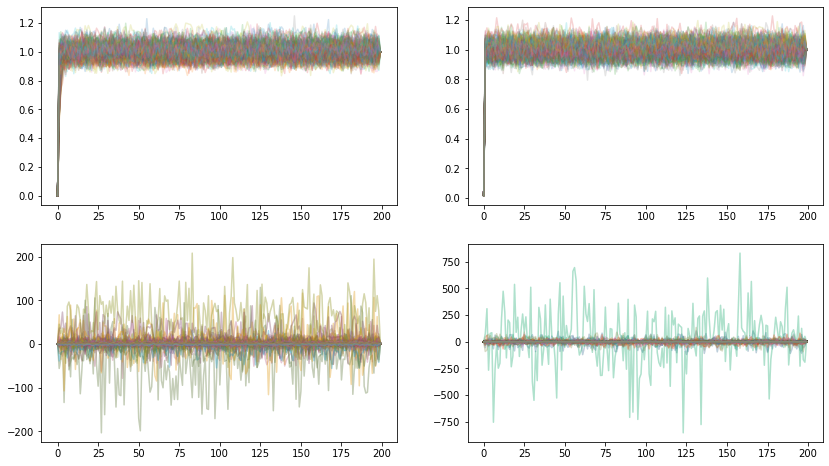

In [18]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R/cov_R[-1], alpha=0.2);
plt.subplot(2,2,2)
plt.plot(cov_S/cov_S[-1], alpha=0.2);
plt.subplot(2,2,3)
plt.plot(cov_H/cov_H[-1], alpha=0.2);
plt.subplot(2,2,4)
plt.plot(cov_Z/cov_Z[-1], alpha=0.2);

In [19]:
stationari_treshold = 500

In [20]:
results.shape

(95, 4, 1600, 2000)

In [21]:
Rx,Ry, Sx, Sy = results[...,stationari_treshold::10].var(axis=2).transpose(1,0,2)
Lx = results[:,0] * results[:,3]
Ly = results[:,1] * results[:,2]

Hx = Lx.mean(axis=1)
Hy = Ly.mean(axis=1)

In [22]:
df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)
df["Ry"], df["Ry_err"]= mean_with_err(Ry,axis=-1)
df["Sx"], df["Sx_err"]= mean_with_err(Sx,axis=-1)
df["Sy"], df["Sy_err"]= mean_with_err(Sy,axis=-1)
df["Hx"], df["Hx_err"]= mean_with_err(Hx,axis=-1)
df["Hy"], df["Hy_err"]= mean_with_err(Hy,axis=-1)

# df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)


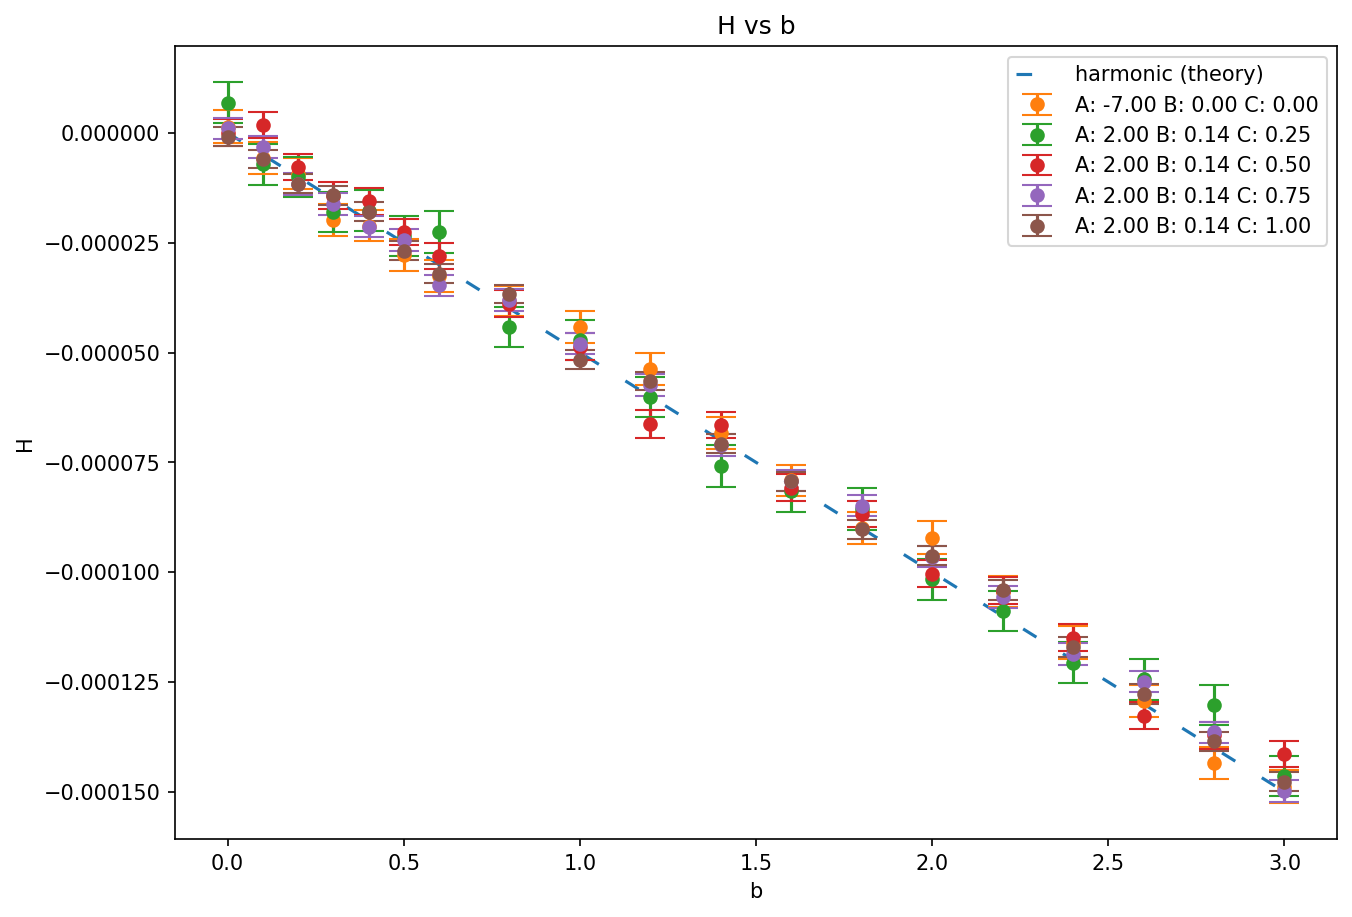

In [23]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(*zip(*[(b, get_RSH(-7, 0,100,b,10)[2]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err, capsize=7, marker="o", ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

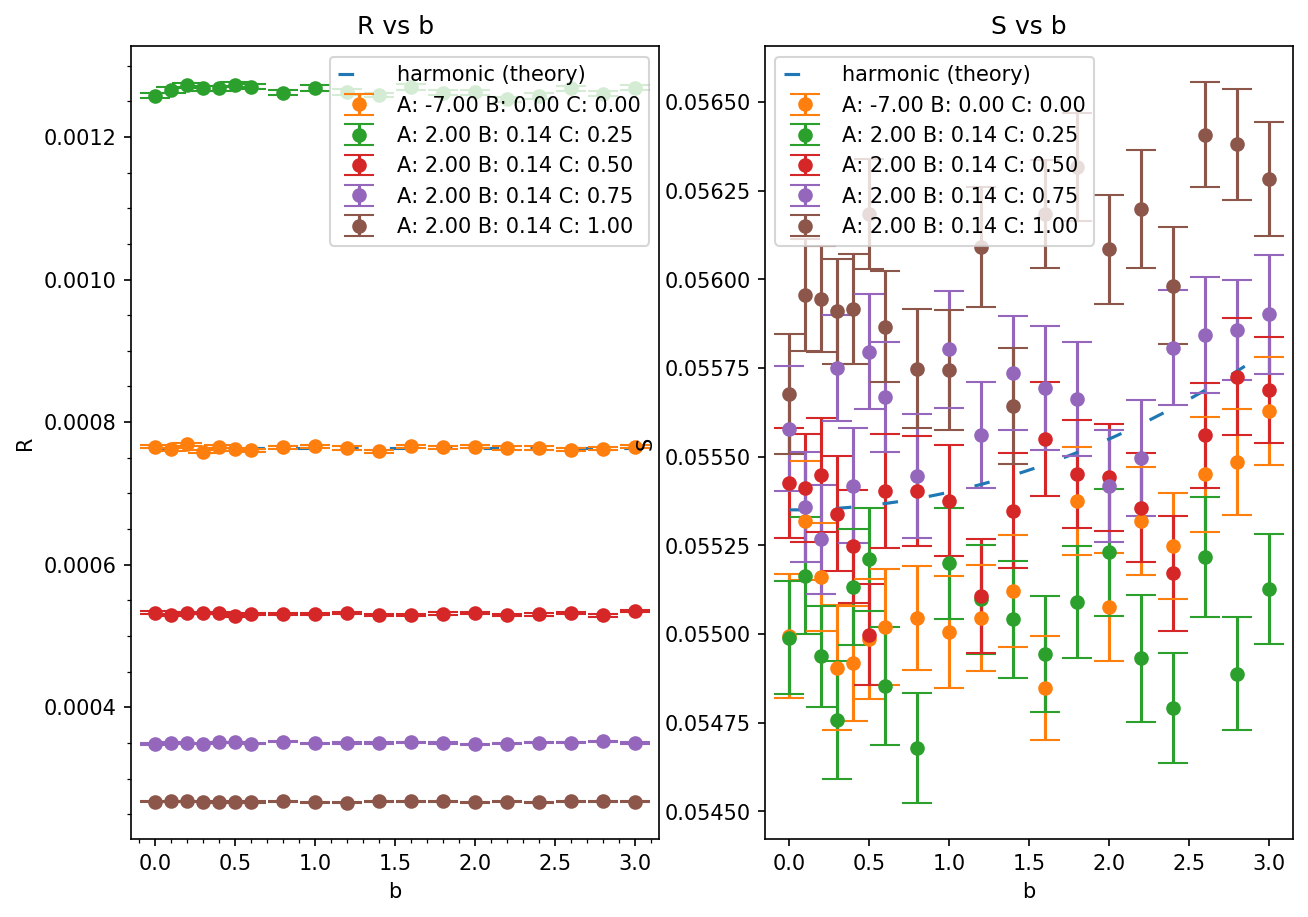

In [25]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.subplot(121)
plt.title("R vs b")
plt.xlabel("b");plt.ylabel("R")
plt.plot(*zip(*[(b, get_RSH(-7, 0,100,b,10)[0]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Rx, yerr=gp.Rx_err, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.minorticks_on()
plt.legend()

plt.subplot(122)
plt.title("S vs b")
plt.xlabel("b");plt.ylabel("S")
plt.plot(*zip(*[(b, get_RSH(-7, 0,100,b,10)[1]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Sx, yerr=gp.Sx_err, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.legend()

In [27]:
2/0.14/2

7.142857142857142

In [ ]:
gb.groups

In [ ]:
dir(gb)

In [ ]:
R_sample = results.var(axis=2)[:,0] 
S_sample = results.var(axis=2)[:,2]

In [ ]:
L = (results[:,0] * results[:,3] - results[:,1] * results[:,2])
H_sample = L.mean(axis=1)/2

In [ ]:
H_sample.shape

In [ ]:
H_sample[:,-3000:].mean(axis=1)

In [ ]:
np.sqrt(H_sample[:,-3000:].var(axis=1)/3000)

In [ ]:
H

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(S, S_sample[..., -1])
plt.subplot(132)
plt.scatter(R, R_sample[..., -1])
plt.subplot(133)
plt.scatter(H, H_sample[..., -1])

In [ ]:
results.shape

In [ ]:
L.shape

In [ ]:
# T = results[:,2,:,:]
T = L/2
hlines = H

In [ ]:
T.shape[0]

In [ ]:
fig, axs = plt.subplots(1+T.shape[0]//2,2,figsize=(14,8),dpi=120)
for ax, xi,h in zip(axs.flatten(),T[:,:,:], hlines):
    ax.plot(time, xi.mean(axis=0))
    ax.hlines(y=h, xmin=0, xmax=max(time), colors="r")
# plt.show()

In [ ]:
L.shape

In [ ]:
plt.hist(L[0,:,-1], bins=100);

In [ ]:
L[1,:,-1].mean()

In [ ]:
sorted(L[1,:,-1])[1600]

In [ ]:
L.shape

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(L[1,2,3000:])